In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.dynamics import mockstream
from gala.units import galactic

In [2]:
g = GaiaData(Table.read('../data/gd1_tbl.fits'))
gd1_gal = coord.Galactic(l=g[g.parallax>0].skycoord.galactic.l,
                         b=g[g.parallax>0].skycoord.galactic.b)

### Distance from Sergey's paper:

In [3]:
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)
gd1_c = c.transform_to(gc.GD1)

In [4]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

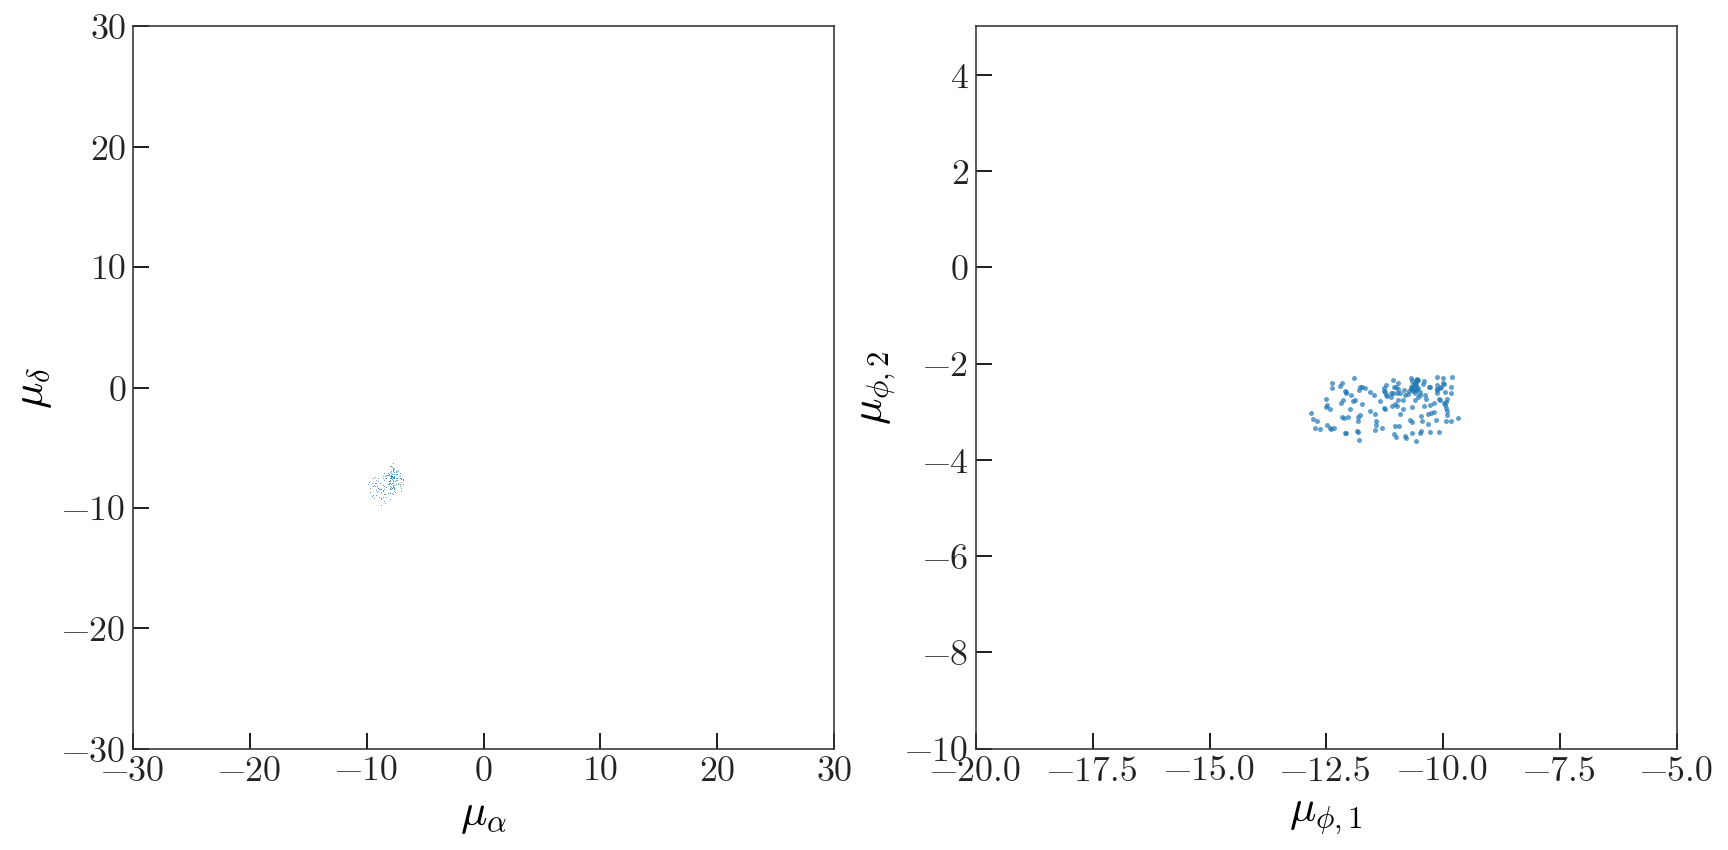

In [5]:
mask = (np.abs(gd1_c.phi2) < 1*u.deg) & (gd1_c.phi1 > (360-15)*u.deg)  & (gd1_c.phi1 < (360-9)*u.deg)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.plot(g.pmra[mask], g.pmdec[mask], 
        marker=',', linestyle='none', alpha=0.7)

ax.set_xlim(-30, 30.)
ax.set_ylim(-30, 30)
ax.set_xlabel(r'$\mu_\alpha$')
ax.set_ylabel(r'$\mu_\delta$')

ax = axes[1]
ax.plot(gd1_c.pm_phi1_cosphi2.to(u.mas/u.yr)[mask], 
        gd1_c.pm_phi2.to(u.mas/u.yr)[mask], 
        marker='.', linestyle='none', alpha=0.7)

ax.set_xlim(-20, -5.)
ax.set_ylim(-10, 5)
ax.set_xlabel(r'$\mu_{\phi,1}$')
ax.set_ylabel(r'$\mu_{\phi,2}$')

fig.set_facecolor('w')
fig.tight_layout()

In [6]:
(np.median(gd1_c.pm_phi1_cosphi2.to(u.mas/u.yr)[mask]), 
 np.median(gd1_c.pm_phi2.to(u.mas/u.yr)[mask]))

(<Quantity -10.86559795 mas / yr>, <Quantity -2.74963843 mas / yr>)

In [7]:
# pm_phi1_med = np.median(gd1_c.pm_phi1_cosphi2.to(u.mas/u.yr)[mask])
# pm_phi2_med = np.median(gd1_c.pm_phi2.to(u.mas/u.yr)[mask])
pm_phi1_med = -10.*u.mas/u.yr
pm_phi2_med = -2.*u.mas/u.yr

In [8]:
w0_gd1 = gc.GD1(phi1=(360-12)*u.deg, phi2=-1*u.deg, 
                distance=gd1_dist(coord.Angle((360-12)*u.deg)),
                pm_phi1_cosphi2=pm_phi1_med,
                pm_phi2=pm_phi2_med,
                radial_velocity=-215*u.km/u.s)

w0 = gd.PhaseSpacePosition(w0_gd1.transform_to(coord.Galactocentric).cartesian)

In [9]:
mw = gp.Hamiltonian(gp.MilkyWayPotential())

In [112]:
orbit = mw.integrate_orbit(w0, dt=-0.2*u.Myr, n_steps=20000)
# orbit = mw.integrate_orbit(w0, dt=-1*u.Myr, n_steps=4000)

Text(0.5,22.25,'$R$ [$\\mathrm{kpc}$]')

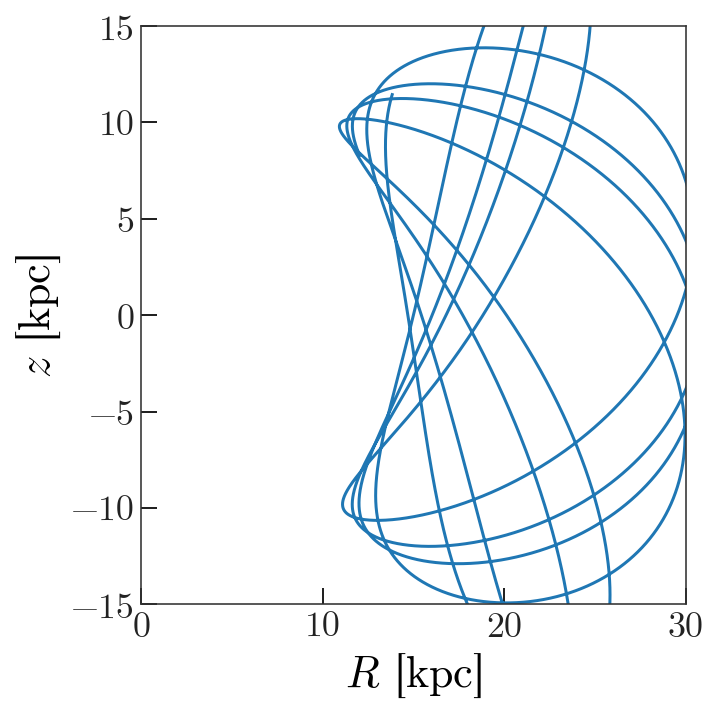

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = orbit.cylindrical.plot(['rho', 'z'], axes=[ax])
ax.set_xlim(0, 30)
ax.set_ylim(-15, 15)
ax.set_xlabel('$R$ [{0:latex}]'.format(u.kpc))

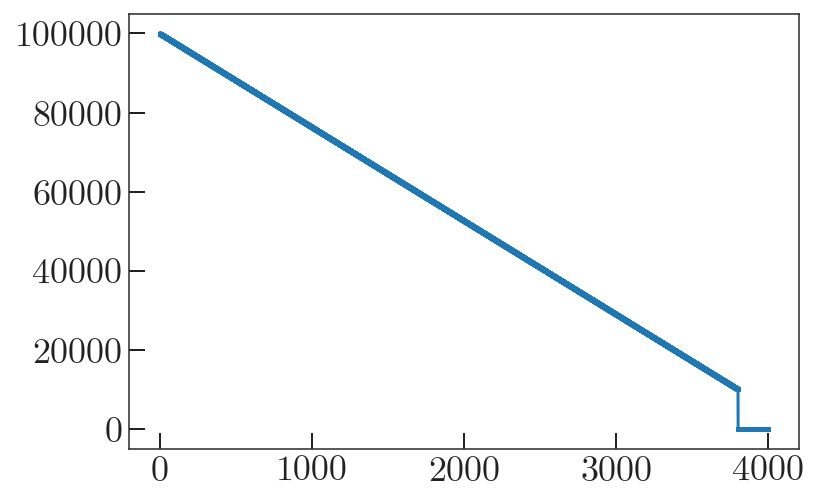

In [114]:
orbit_ = gd.Orbit(pos=orbit[::-1].pos, vel=orbit[::-1].vel, 
                  t=np.linspace(0, abs(orbit.t.min().value), len(orbit.t))*u.Myr)

t_disrupt = 3800*u.Myr
n_times = (orbit_.t < t_disrupt).sum()
prog_mass = np.linspace(1e5, 1E4, n_times)
prog_mass = np.concatenate((prog_mass, np.zeros(len(orbit_.t) - n_times))) * u.Msun

plt.plot(orbit_.t, prog_mass)

In [115]:
# stream = mockstream.fardal_stream(mw, orbit[::-1], 1E3*u.Msun, release_every=1)
stream = mockstream.dissolved_fardal_stream(mw, orbit_, prog_mass=prog_mass, 
                                            t_disrupt=t_disrupt, release_every=1)
# stream = mockstream.streakline_stream(mw, orbit[::-1], 5e4*u.Msun, release_every=1)

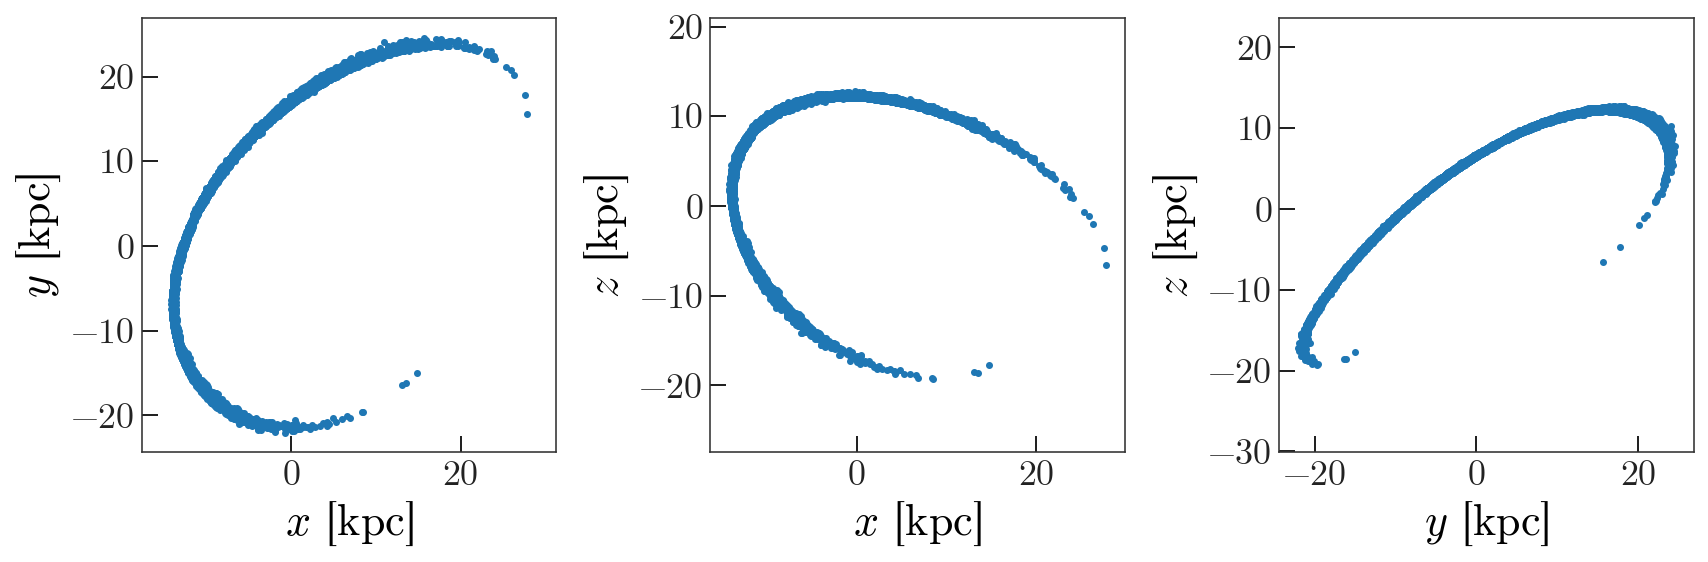

In [116]:
_ = stream.plot()

In [117]:
stream_gd1 = stream.to_coord_frame(gc.GD1)

In [118]:
from scipy.stats import norm

(-80, 10)

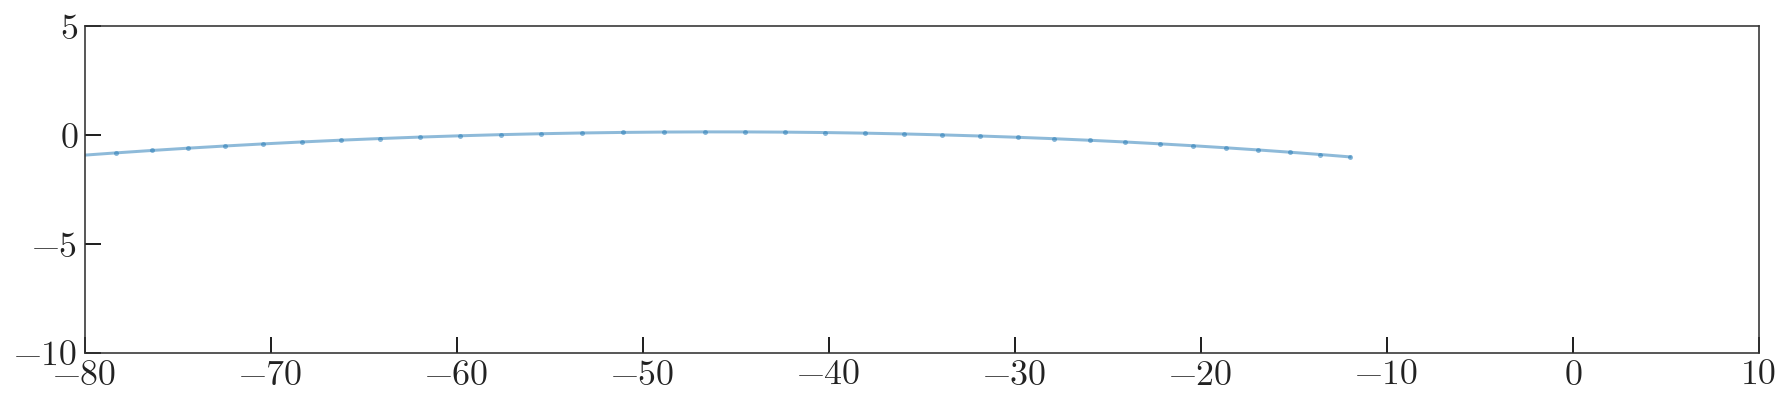

In [134]:
orbit2 = mw.integrate_orbit(w0, dt=1*u.Myr, n_steps=50)
orbit_gd1 = orbit2.to_coord_frame(gc.GD1)

fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True, sharey=True)

ax.plot(orbit_gd1.phi1.wrap_at(180*u.deg).degree, 
        orbit_gd1.phi2.degree, 
        alpha=0.5)
ax.set_ylim(-10, 5)
ax.set_xlim(-80, 10)

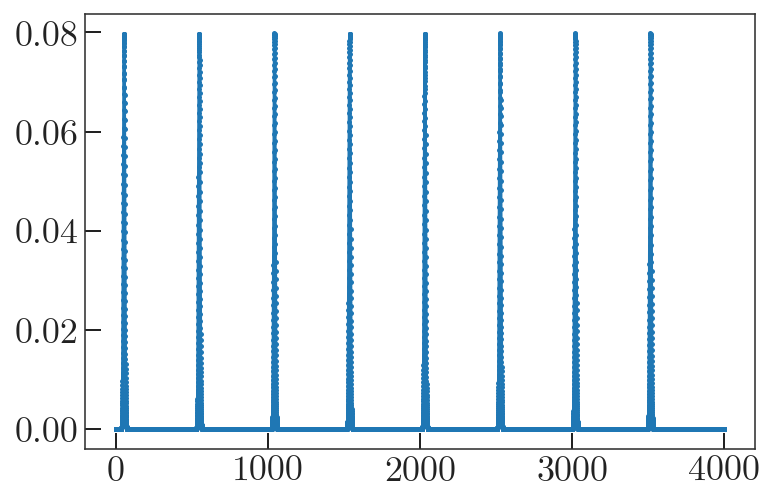

In [122]:
_, peri_times = orbit_.pericenter(func=None, return_times=True)

def shock_func(t):
    # dt = peri_times[None] - t[:, None]
    return np.sum(norm.pdf(peri_times[None].to(u.Myr).value, 
                           loc=t[:, None].to(u.Myr).value, 
                           scale=5.), axis=1)

plt.plot(orbit_.t, shock_func(orbit_.t))

In [123]:
weights = np.zeros(stream.shape)
weights[::2] = shock_func(orbit_.t)
weights[::2] = weights[::2] / weights[::2].max()
weights[1::2] = weights[0::2]

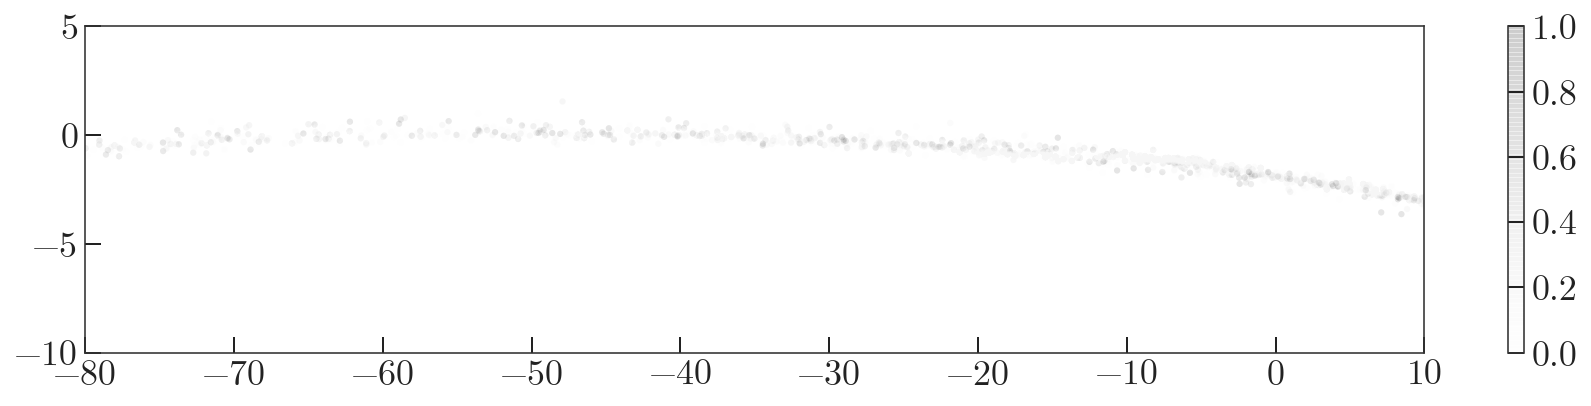

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True, sharey=True)

cs = ax.scatter(stream_gd1.phi1.wrap_at(180*u.deg).degree, 
                stream_gd1.phi2.degree, 
                c=weights, alpha=0.1, linewidth=0,
                cmap='Greys', s=10)
ax.set_ylim(-10, 5)
ax.set_xlim(-80, 10)
fig.colorbar(cs)

In [88]:
np.abs(orbit.estimate_period())

<Quantity 494.14285714 Myr>

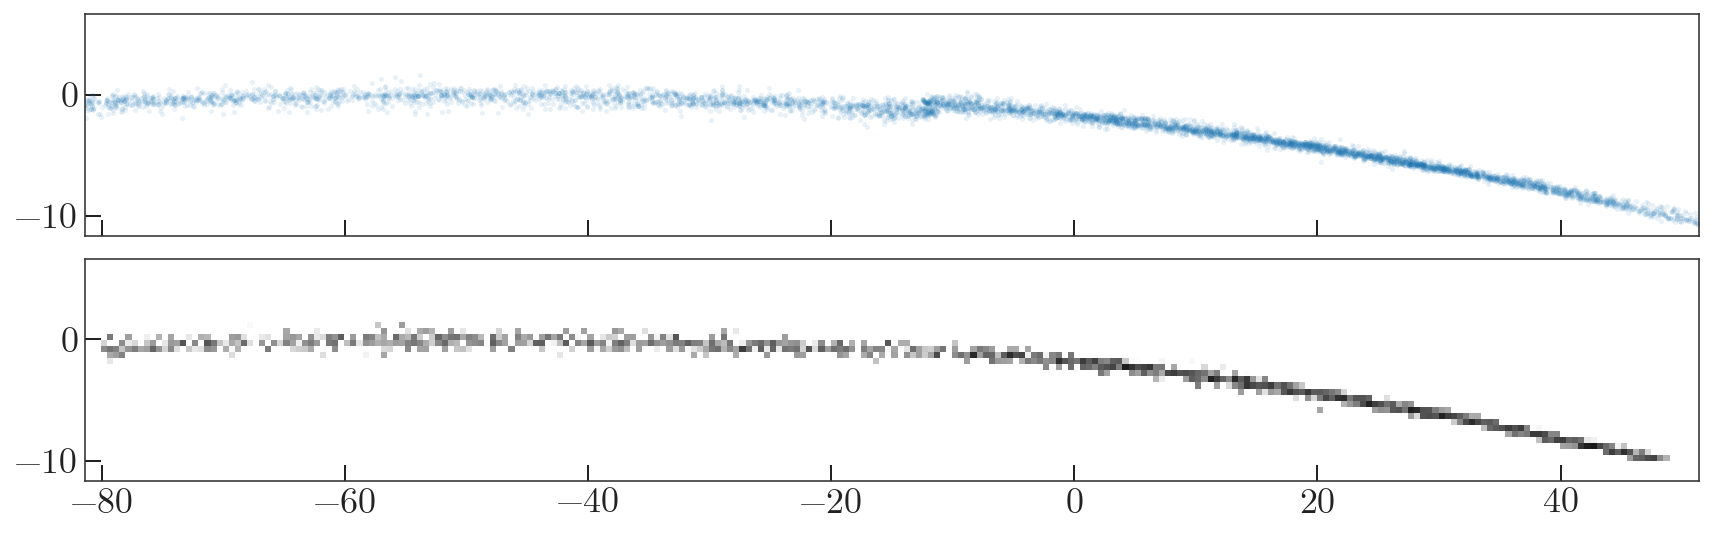

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(12, 3.8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(stream_gd1.phi1.wrap_at(180*u.deg).degree, 
        stream_gd1.phi2.degree, 
        marker='.', alpha=0.1, linestyle='none')
ax.set_ylim(-10, 5)
ax.set_xlim(-80, 50)
ax.set_aspect('equal')

# ---
x = stream_gd1.phi1.wrap_at(180*u.deg).degree
y = stream_gd1.phi2.degree
H, xe, ye = np.histogram2d(x, y, weights=weights,
                           bins=(np.arange(-80, 50, 0.5), np.arange(-10, 5, 0.5)))
ax = axes[1]
ax.pcolormesh(xe, ye, np.log(H.T + 1E-10), vmin=-7, vmax=-2, cmap='Greys')

ax.set_aspect('equal')

fig.tight_layout()

(300, 360)

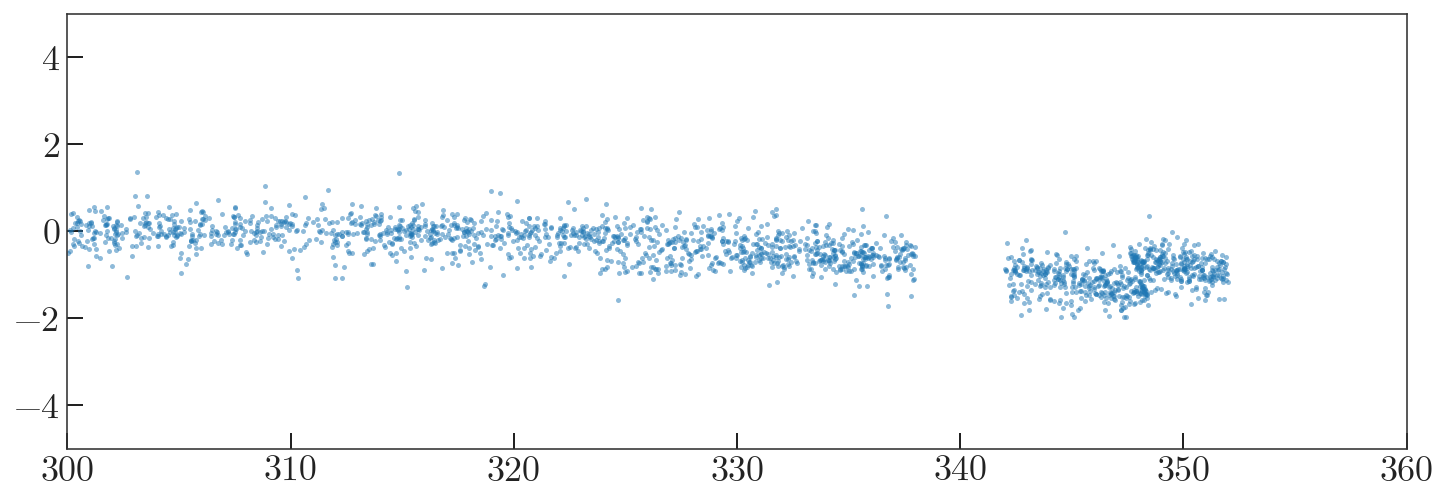

In [129]:
chunk_mask = np.logical_not((stream_gd1.phi1 > 338*u.deg) & (stream_gd1.phi1 < 342*u.deg))
chunk_mask &= (stream_gd1.phi1 > 300*u.deg) & (stream_gd1.phi1 < 352*u.deg)
chunk_mask &= np.abs(stream_gd1.phi2) < 2*u.deg

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(stream_gd1.phi1[chunk_mask], stream_gd1.phi2[chunk_mask], 
        marker='.', alpha=0.5, linestyle='none')
ax.set_ylim(-5, 5)
ax.set_xlim(300, 360)

In [130]:
def reflex(c):
    c_oph_hack = gc.GD1(phi1=c.phi1, phi2=c.phi2,
                        distance=gd1_dist(c.phi1),
                        pm_phi1_cosphi2=c.pm_phi1_cosphi2,
                        pm_phi2=c.pm_phi2,
                        radial_velocity=c.radial_velocity)
    
    # Correct for reflex motion
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = c_oph_hack.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    return coord.Galactic(rep).transform_to(gc.GD1)

In [131]:
stream_gd1_reflex = reflex(stream_gd1)

(-4, 4)

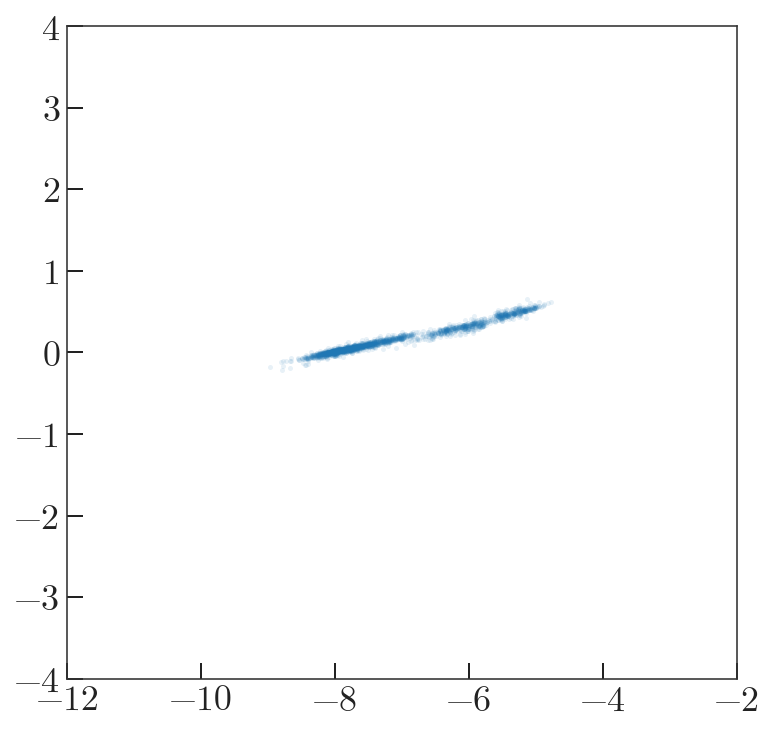

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(stream_gd1_reflex.pm_phi1_cosphi2[chunk_mask].to(u.mas/u.yr), 
        stream_gd1_reflex.pm_phi2[chunk_mask].to(u.mas/u.yr), 
        marker='.', alpha=0.1, linestyle='none')
ax.set_xlim(-12, -2)
ax.set_ylim(-4, 4)

(0.49398692203624744, 0.48511278582974415)

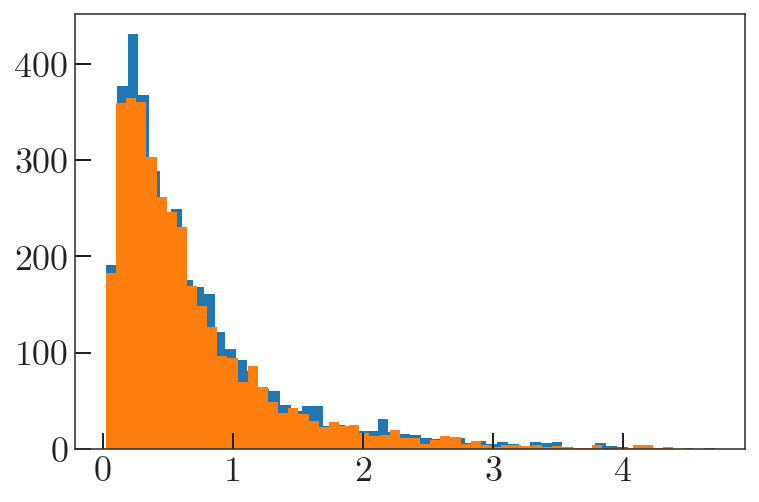

In [133]:
plt.hist(g.pmra_error.value, bins='auto');
plt.hist(g.pmdec_error.value, bins='auto');
np.median(g.pmra_error.value), np.median(g.pmdec_error.value)

In [134]:
obs_pm_phi1 = np.random.normal(stream_gd1_reflex.pm_phi1_cosphi2[chunk_mask].to(u.mas/u.yr).value, 0.2)
obs_pm_phi2 = np.random.normal(stream_gd1_reflex.pm_phi2[chunk_mask].to(u.mas/u.yr).value, 0.2)

In [135]:
from matplotlib.gridspec import GridSpec

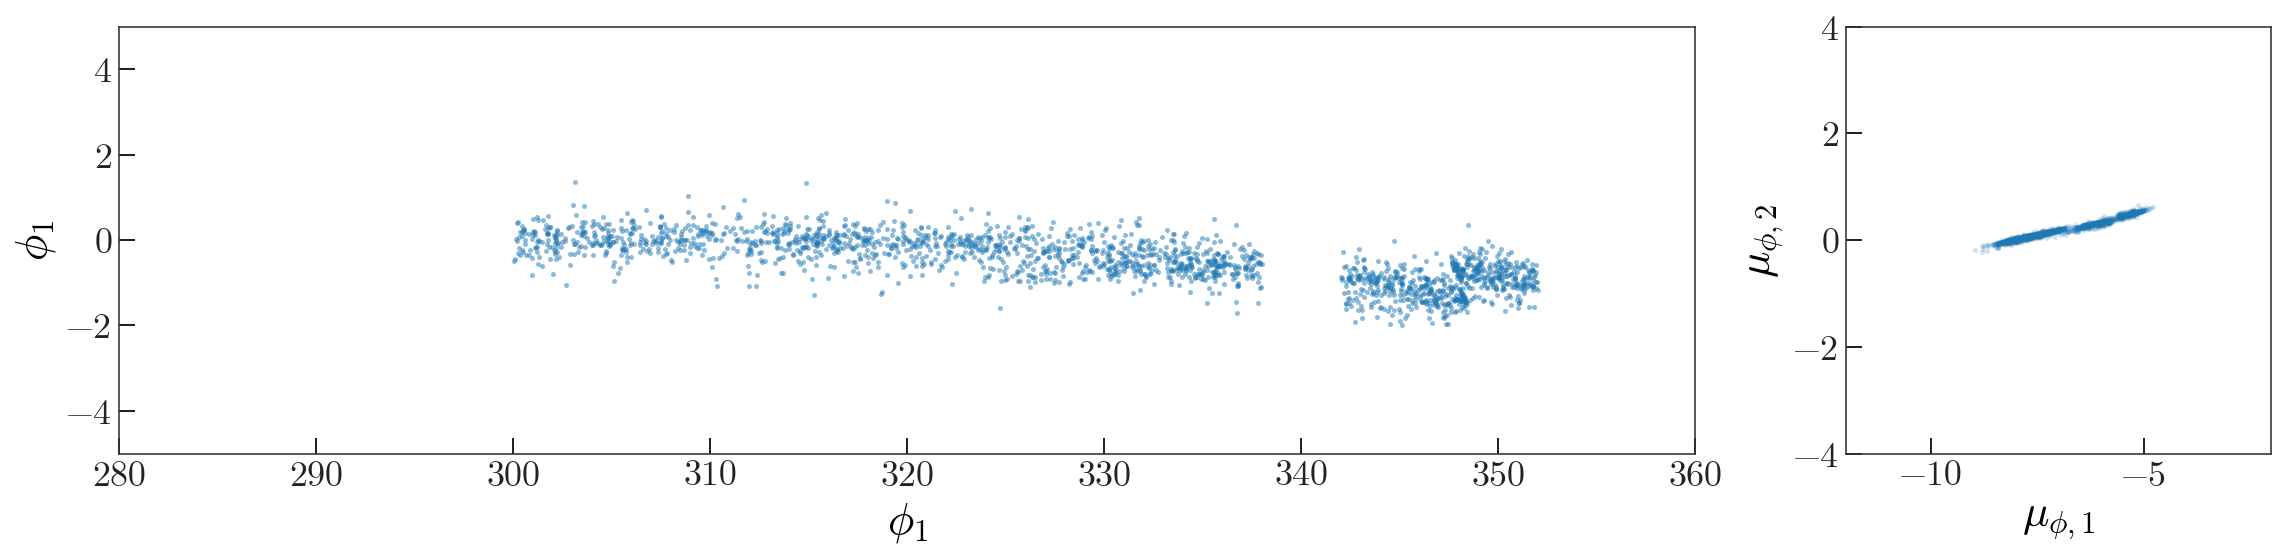

In [136]:
fig = plt.figure(figsize=(16,4))

gs = GridSpec(1, 4)

ax = fig.add_subplot(gs[:3])
ax.plot(stream_gd1.phi1[chunk_mask], stream_gd1.phi2[chunk_mask], 
        marker='.', alpha=0.5, linestyle='none')
ax.set_ylim(-5, 5)
ax.set_xlim(280, 360)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_1$')

ax = fig.add_subplot(gs[3])
ax.plot(stream_gd1_reflex.pm_phi1_cosphi2[chunk_mask].to(u.mas/u.yr), 
        stream_gd1_reflex.pm_phi2[chunk_mask].to(u.mas/u.yr), 
        marker='.', alpha=0.2, linestyle='none')
ax.set_xlim(-12, -2)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$\mu_{\phi, 1}$')
ax.set_ylabel(r'$\mu_{\phi, 2}$')

fig.tight_layout()

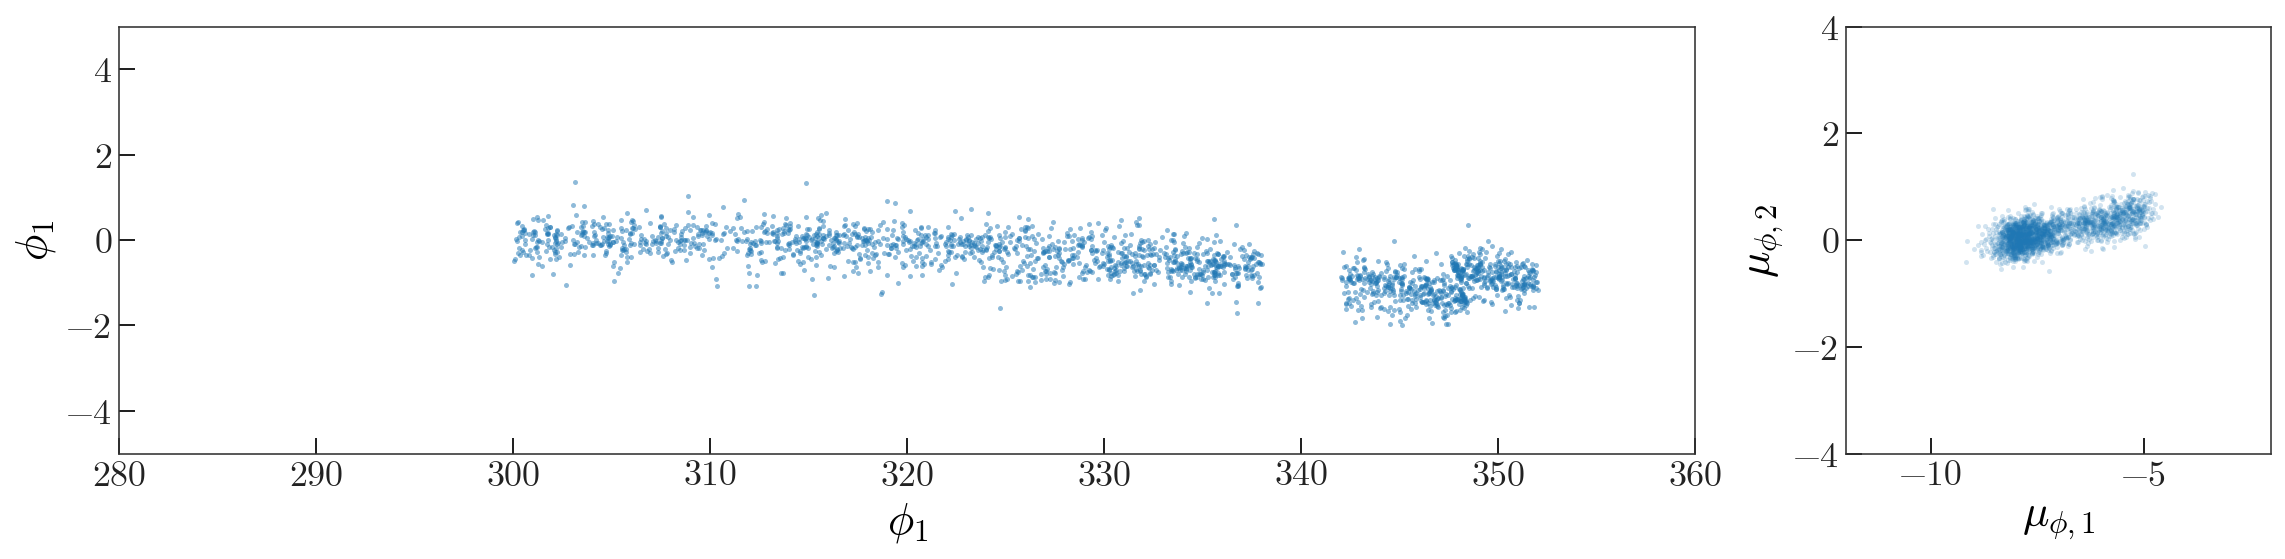

In [137]:
fig = plt.figure(figsize=(16,4))

gs = GridSpec(1, 4)

ax = fig.add_subplot(gs[:3])
ax.plot(stream_gd1.phi1[chunk_mask], stream_gd1.phi2[chunk_mask], 
        marker='.', alpha=0.5, linestyle='none')
ax.set_ylim(-5, 5)
ax.set_xlim(280, 360)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_1$')

ax = fig.add_subplot(gs[3])
ax.plot(obs_pm_phi1, obs_pm_phi2,
        marker='.', alpha=0.2, linestyle='none')
ax.set_xlim(-12, -2)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$\mu_{\phi, 1}$')
ax.set_ylabel(r'$\mu_{\phi, 2}$')

fig.tight_layout()

In [96]:
hogg_mask = stream_gd1.phi1[chunk_mask] > 340*u.deg

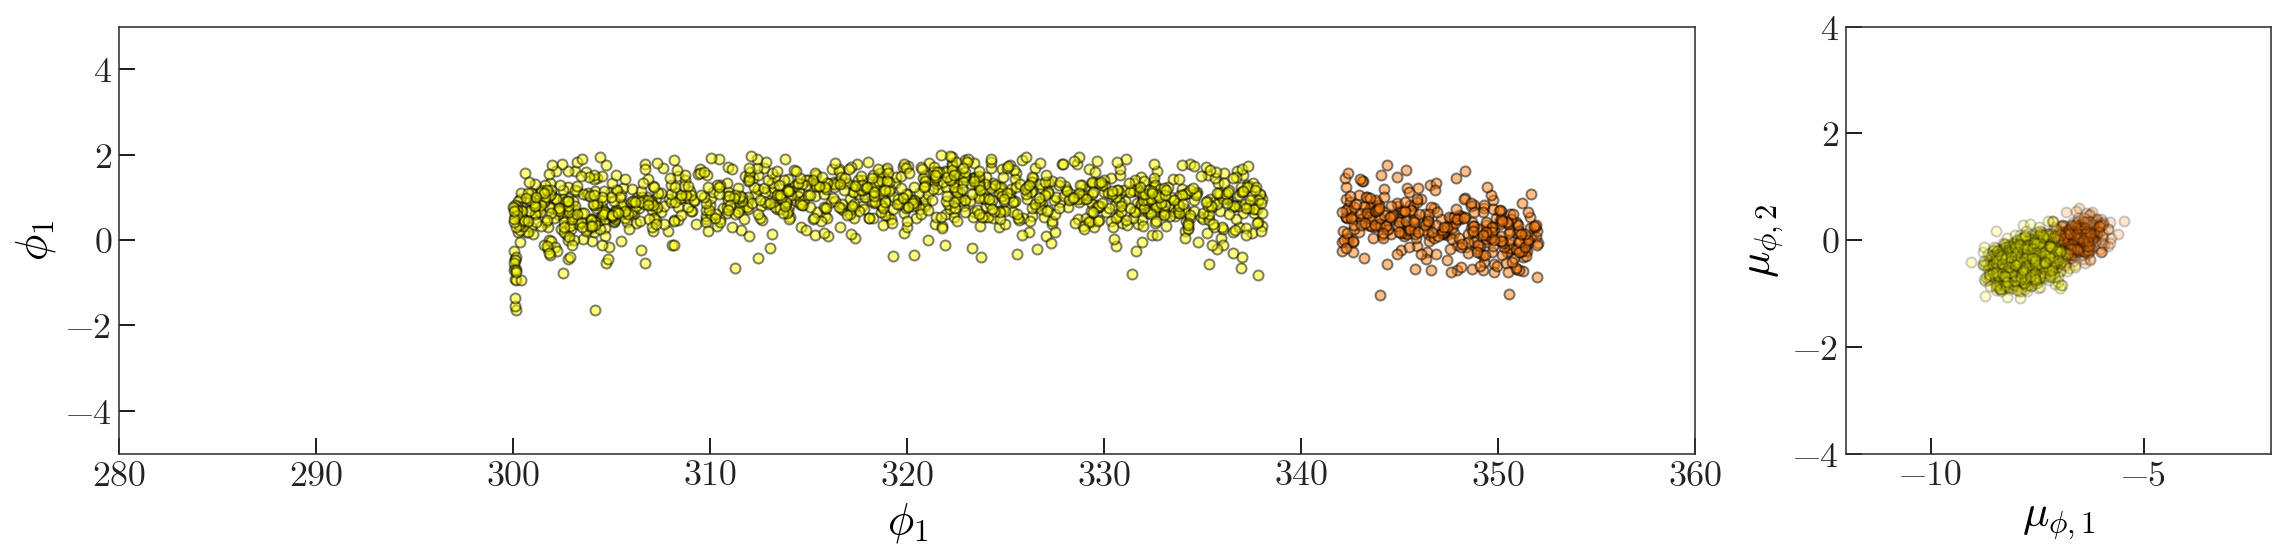

In [97]:
fig = plt.figure(figsize=(16,4))

gs = GridSpec(1, 4)

ax = fig.add_subplot(gs[:3])
ax.plot(stream_gd1.phi1[chunk_mask][hogg_mask], stream_gd1.phi2[chunk_mask][hogg_mask], 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.5, linestyle='none', color='tab:orange')
ax.plot(stream_gd1.phi1[chunk_mask][~hogg_mask], stream_gd1.phi2[chunk_mask][~hogg_mask], 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.5, linestyle='none', color='yellow')
ax.set_ylim(-5, 5)
ax.set_xlim(280, 360)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_1$')

ax = fig.add_subplot(gs[3])
ax.plot(obs_pm_phi1[hogg_mask], obs_pm_phi2[hogg_mask], 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.2, linestyle='none', color='tab:orange')
ax.plot(obs_pm_phi1[~hogg_mask], obs_pm_phi2[~hogg_mask],
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.2, linestyle='none', color='yellow')
ax.set_xlim(-12, -2)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$\mu_{\phi, 1}$')
ax.set_ylabel(r'$\mu_{\phi, 2}$')

fig.tight_layout()

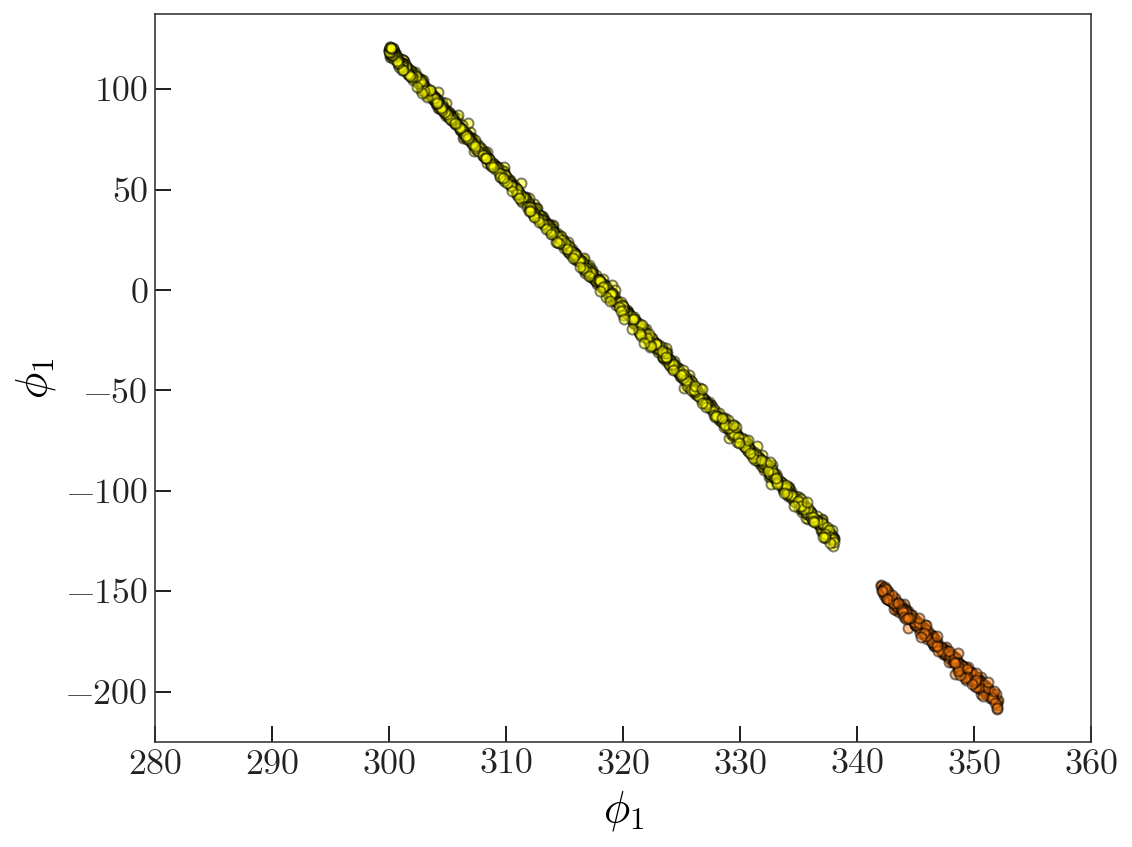

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(stream_gd1.phi1[chunk_mask][hogg_mask], 
        stream_gd1.radial_velocity[chunk_mask][hogg_mask].to(u.km/u.s), 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.5, linestyle='none', color='tab:orange')
ax.plot(stream_gd1.phi1[chunk_mask][~hogg_mask], 
        stream_gd1.radial_velocity[chunk_mask][~hogg_mask].to(u.km/u.s), 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.5, linestyle='none', color='yellow')

# ax.set_ylim(-5, 5)
ax.set_xlim(280, 360)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_1$')

fig.tight_layout()

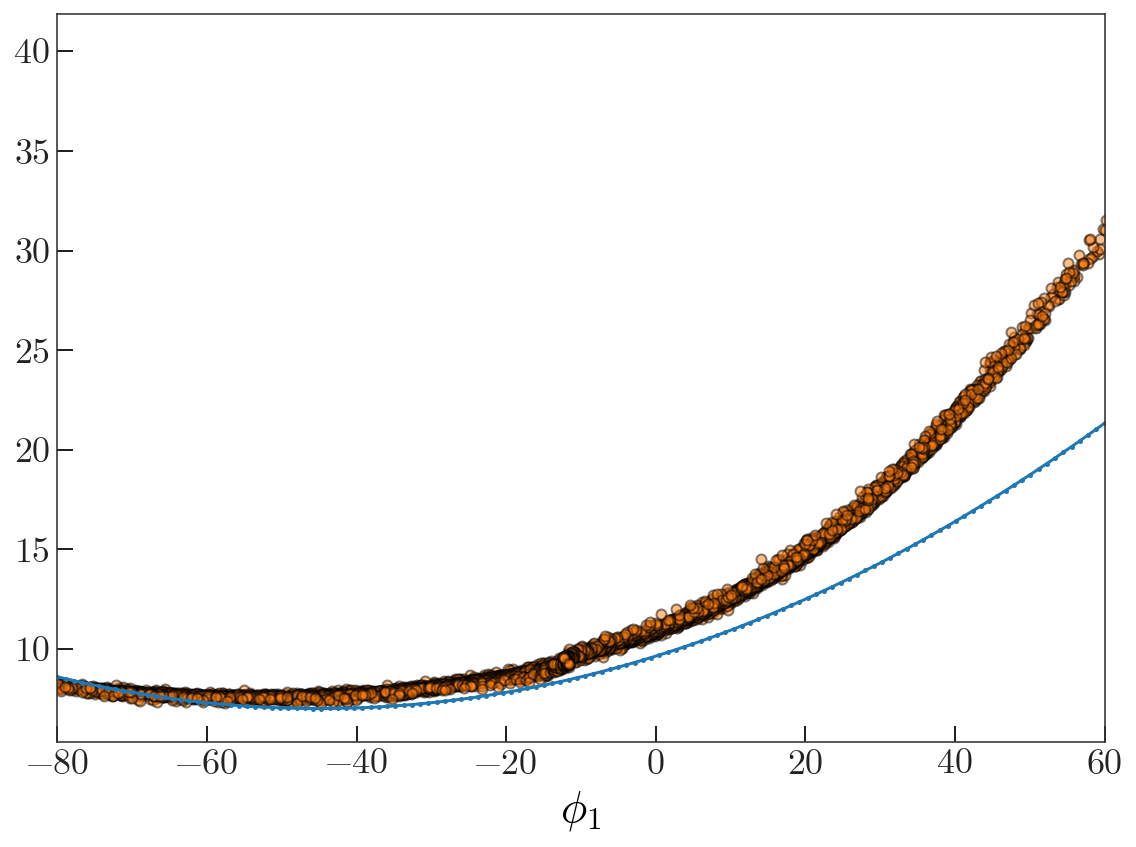

In [138]:
def gd1_dist2(phi1):
    _phi1 = phi1.wrap_at(180*u.deg).degree
    return 1.3E-3 * (_phi1 - (-45))**2 + 7

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(stream_gd1.phi1.wrap_at(180*u.deg).value, 
        stream_gd1.distance, 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.5, linestyle='none', color='tab:orange')

xgrid = np.linspace(-80, 60, 128)
ax.plot(xgrid, gd1_dist2(coord.Angle(xgrid*u.deg)))

# ax.set_ylim(-5, 5)
ax.set_xlim(-80, 60)
ax.set_xlabel(r'$\phi_1$')
# ax.set_ylabel(r'$\phi_1$')

fig.tight_layout()

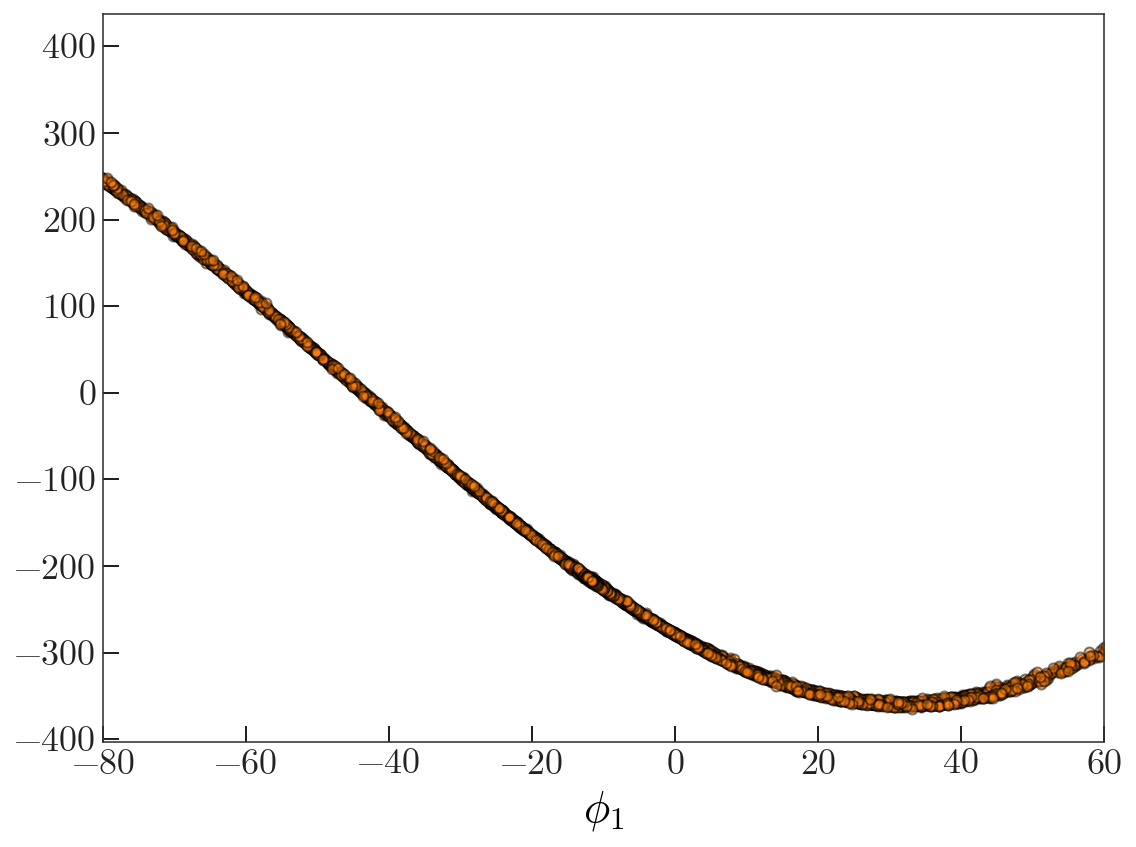

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(stream_gd1.phi1.wrap_at(180*u.deg).value, 
        stream_gd1.radial_velocity.to(u.km/u.s), 
        markeredgecolor='k', markeredgewidth=1, marker='o', 
        alpha=0.5, linestyle='none', color='tab:orange')

# ax.set_ylim(-5, 5)
ax.set_xlim(-80, 60)
ax.set_xlabel(r'$\phi_1$')
# ax.set_ylabel(r'$\phi_1$')

fig.tight_layout()

In [140]:
apogee_lamost = ascii.read("""Name  RA   Dec   v_helio    v_err
GD1_03 129.00423095175316 14.488908519942708 208.948 0.188823
GD1_04 129.07388082452468 14.511743503120572 65.0177 0.0072105
GD1_15 138.88154112814536 22.442549100992707 262.18 0.0309619
GD1_06 132.92319419116868 20.038946348149242 51.0 7.5
GD1_08 133.28653801860463 17.224029926832998 2.1 7.4
GD1_08 133.28653801860463 17.224029926832998 -9.9 4.9
GD1_08 133.28653801860463 17.224029926832998 -9.0 6.7
GD1_08 133.28653801860463 17.224029926832998 -9.5 5.5
GD1_10 134.50153432851073 14.31857976004548 27.1 12.1
GD1_11 135.1101314569833 18.909718716668543 197.9 21.3
GD1_11 135.1101314569833 18.909718716668543 204.8 2.1
GD1_11 135.1101314569833 18.909718716668543 205.6 8.6
GD1_12 135.9009054642406 9.273686810558866 132.5 11.9
GD1_12 135.9009054642406 9.273686810558866 129.9 6.7
GD1_13 136.73223461696193 21.721454425170514 86.6 2.3
GD1_15 138.88154112814536 22.442549100992707 256.9 6.4
GD1_15 138.88154112814536 22.442549100992707 261.8 14.1
GD1_17 143.01536310921844 29.86647724664508 -31.4 25.0
GD1_17 143.01536310921844 29.86647724664508 -27.6 36.3
GD1_17 143.01536310921844 29.86647724664508 -22.5 10.2
GD1_17 143.01536310921844 29.86647724664508 -23.7 21.4
GD1_20 156.56160997745602 43.25205960807197 -56.5 2.1
GD1_22 163.84033000661432 43.89622482799789 -11.2 17.2
GD1_25 174.31029825731488 59.206607469764954 109.2 4.7
GD1_27 178.04944930606578 58.07752457330583 -14.4 11.8""")
apogee_lamost_c = coord.SkyCoord(ra=apogee_lamost['RA']*u.deg, dec=apogee_lamost['Dec']*u.deg,
                                 pm_ra_cosdec=[0]*len(apogee_lamost)*u.mas/u.yr,
                                 pm_dec=[0]*len(apogee_lamost)*u.mas/u.yr,
                                 radial_velocity=apogee_lamost['v_helio']*u.km/u.s)
apogee_lamost_gd1 = apogee_lamost_c.transform_to(gc.GD1)
apogee_lamost_gd1_reflex = reflex(apogee_lamost_gd1)

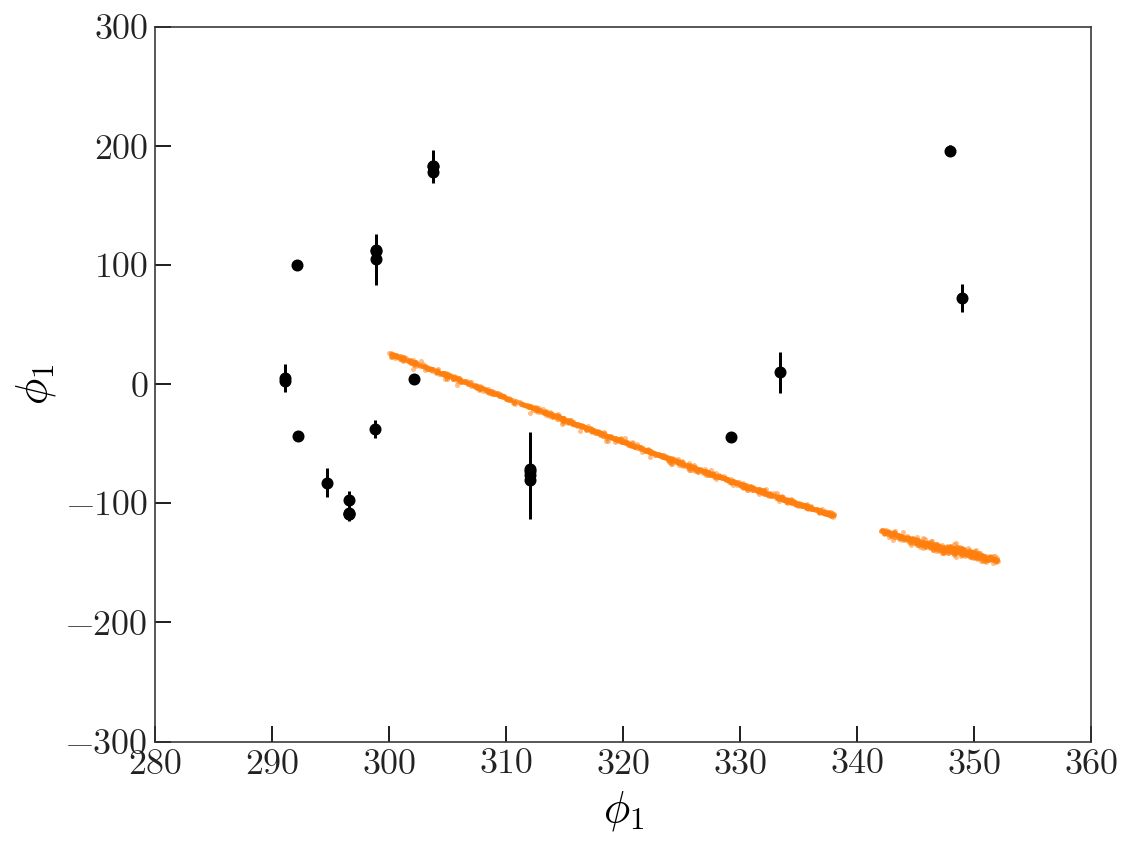

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(stream_gd1_reflex.phi1[chunk_mask], 
        stream_gd1_reflex.radial_velocity[chunk_mask].to(u.km/u.s), 
        marker='.',  alpha=0.5, linestyle='none', color='tab:orange')

ax.scatter(apogee_lamost_gd1_reflex.phi1, 
           apogee_lamost_gd1_reflex.radial_velocity, 
           zorder=100, marker='o', color='k')
ax.errorbar(apogee_lamost_gd1_reflex.phi1.value, 
            apogee_lamost_gd1_reflex.radial_velocity.value, 
            yerr=apogee_lamost['v_err'], linestyle='none',
            zorder=-100, marker='', color='k')

ax.set_ylim(-300, 300)
ax.set_xlim(280, 360)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_1$')

fig.tight_layout()

In [143]:
from gala.mpl_style import center_emph

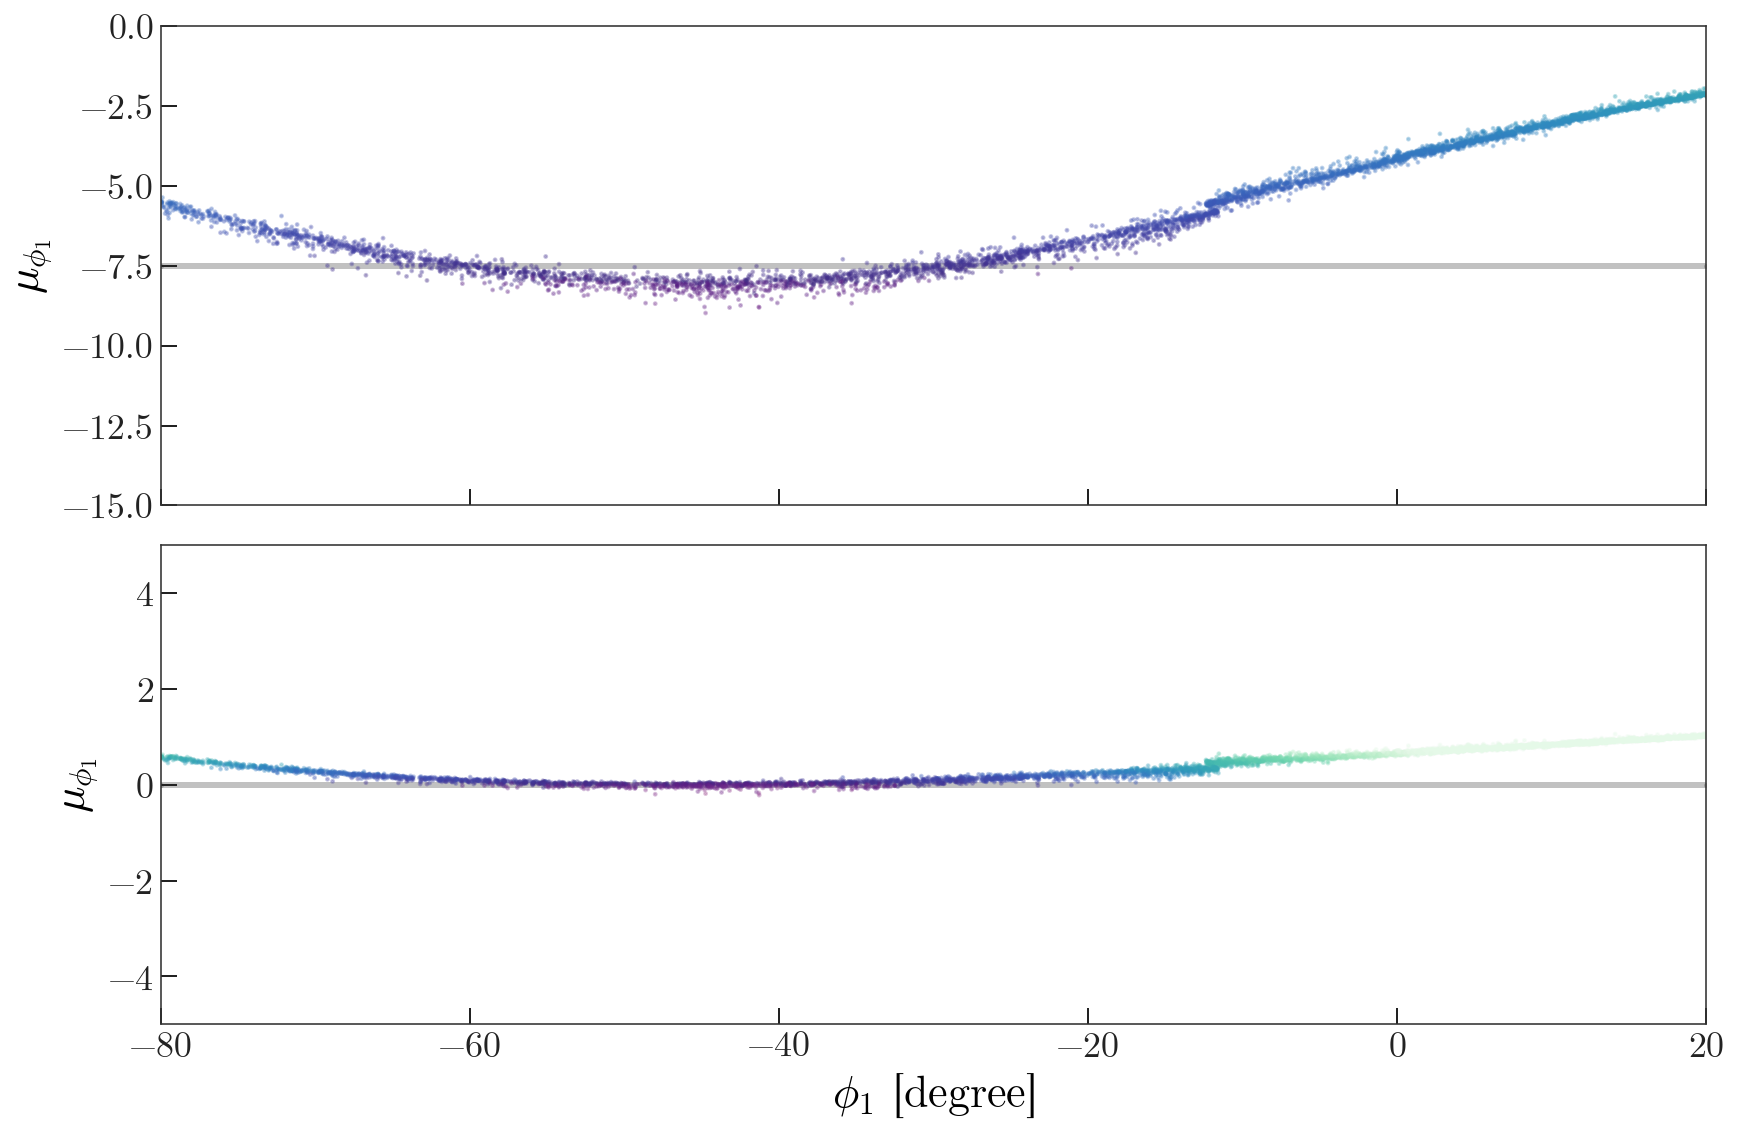

In [147]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax = axes[0]
ax.scatter(stream_gd1_reflex.phi1.wrap_at(180*u.deg).value, 
           stream_gd1_reflex.pm_phi1_cosphi2.to(u.mas/u.yr).value,
           c=stream_gd1_reflex.pm_phi2.to(u.mas/u.yr).value,
           alpha=0.3, marker='.', vmin=-2, vmax=2, cmap=center_emph, s=8)

ax.axhline(-7.5, zorder=-100, alpha=0.4, linewidth=3)

# ax.set_xlabel('$\phi_1$ [degree]')
ax.set_ylabel(r'$\mu_{\phi_1}$')

ax.set_xlim(-80, 20)
ax.set_ylim(-15, 0)

ax = axes[1]
ax.scatter(stream_gd1_reflex.phi1.wrap_at(180*u.deg).value, 
           stream_gd1_reflex.pm_phi2.to(u.mas/u.yr).value,
           c=stream_gd1_reflex.pm_phi1_cosphi2.to(u.mas/u.yr).value,
           alpha=0.3, marker='.', vmin=-12, vmax=-4, cmap=center_emph, s=8)

ax.axhline(0, zorder=-100, alpha=0.4, linewidth=3)

ax.set_xlabel('$\phi_1$ [degree]')
ax.set_ylabel(r'$\mu_{\phi_1}$')

ax.set_ylim(-5, 5)

fig.tight_layout()

Text(0,0.5,'$\\mu_{\\phi,2}$')

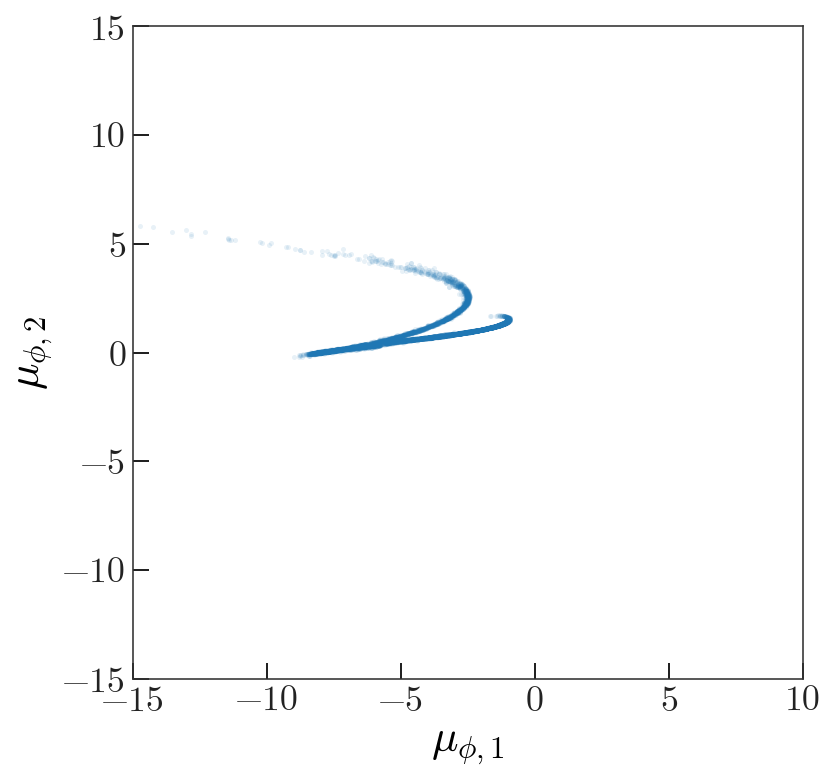

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(stream_gd1_reflex.pm_phi1_cosphi2.to(u.mas/u.yr), 
        stream_gd1_reflex.pm_phi2.to(u.mas/u.yr), 
        marker='.', alpha=0.1, linestyle='none')
ax.set_xlim(-15, 10)
ax.set_ylim(-15, 15)
ax.set_xlabel(r'$\mu_{\phi,1}$')
ax.set_ylabel(r'$\mu_{\phi,2}$')